# sequence prediction sandbox


In [147]:
import torch
from torch import nn

import altair as alt
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import utils as u

In [2]:
seqs8 = [''.join(x) for x in product(['A','C','G','T'], repeat=8)]
print('Total 8mers:',len(seqs8))

Total 8mers: 65536


In [3]:
# if you want to down select
seqs8_200 = u.downselect_list(seqs8,200)

In [13]:
score_dict = {
    'A':20,
    'C':17,
    'G':14,
    'T':11
}
def score_seqs(seqs):
    data = []
    for seq in seqs:
        score = np.mean([score_dict[base] for base in seq])
        data.append([seq,score])
        
    df = pd.DataFrame(data, columns=['seq','score'])
    return df
                  
def score_seqs_motif(seqs):
    data = []
    for seq in seqs:
        score = np.mean([score_dict[base] for base in seq])
        if 'TAT' in seq:
            score += 10
        if 'GCG' in seq:
            score -= 10
        data.append([seq,score])
        
    df = pd.DataFrame(data, columns=['seq','score'])
    return df
    
    
def score_seqs_ordering(seqs):
    data = []
    i=0
    j=0
    for seq in seqs:
        score = np.mean([score_dict[base] for base in seq])
        if 'AA' in seq and 'GG' in seq:
            if seq.index("AA") < seq.index("GG"):
                score -= 10
                i+=1
        if 'TT' in seq and 'CC' in seq:
            if seq.index("TT") < seq.index("CC"):
                score += 10
                j+=1
        data.append([seq,score])
        
    df = pd.DataFrame(data, columns=['seq','score'])
    print(i)
    print(j)
    return df
    

In [14]:
mer8_ordering = score_seqs_ordering(seqs8)

2458
2458


In [12]:
s = "AACTAGTGGA"
s.index("GG")

7

In [15]:
mer8_ordering.head()

,seq,score
0,AAAAAAAA,20.000
1,AAAAAAAC,19.625
2,AAAAAAAG,19.250
3,AAAAAAAT,18.875
4,AAAAAACA,19.625


In [16]:
oracle_8mer_ordering = dict(mer8_ordering[['seq','score']].values)


In [19]:
oracle_8mer_ordering['CTTCCTGG']

24.0

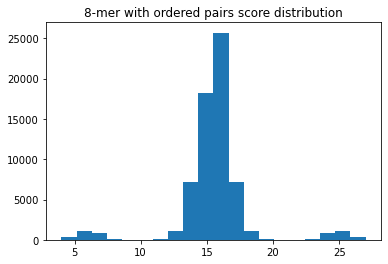

In [20]:
plt.hist(mer8_ordering['score'].values,bins=20)
plt.title("8-mer with ordered pairs score distribution")
plt.show()

### Define some basic model archs for Linear and CNN

In [21]:
class DNA_Linear(nn.Module):
    def __init__(self, seq_len,h1_size):
        super().__init__()
        self.seq_len = seq_len
        
        self.lin = nn.Sequential(
            nn.Linear(4*seq_len, h1_size),
            nn.ReLU(inplace=True),
            nn.Linear(h1_size, 1),
            nn.ReLU(inplace=True)
        )

    def forward(self, xb):
        # Linear wraps up the weights/bias dot product operations
        out = self.lin(xb)
        #print("Lin out shape:", out.shape)
        return out
    

    
class DNA_CNN(nn.Module):
    def __init__(self,
                 seq_len,
                 num_filters=32,
                 kernel_size=3):
        super().__init__()
        self.seq_len = seq_len
        
        self.conv_net = nn.Sequential(
            nn.Conv1d(4, num_filters, kernel_size=kernel_size),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(num_filters*(seq_len-kernel_size+1), 10),
            nn.ReLU(inplace=True),
            nn.Linear(10, 1),
        ) 

    def forward(self, xb):
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        xb = xb.view(-1,self.seq_len,4).permute(0,2,1) 
        #print(xb.shape)
        out = self.conv_net(xb)
        #print("CNN out shape:",out.shape)
        return out

# Single Task, Simple Sequence Regression
#### Linear Regression

In [22]:
def plot_train_test_hist(train_df, test_df,bins=10):
    ''' Check distribution of train/test scores, sanity check that its not skewed'''
    plt.hist(train_df['score'].values,bins=bins,label="train")
    plt.hist(test_df['score'].values,bins=bins,label='test')
    plt.legend()
    plt.xlabel("seq score",fontsize=14)
    plt.ylabel("count",fontsize=14)
    plt.show()

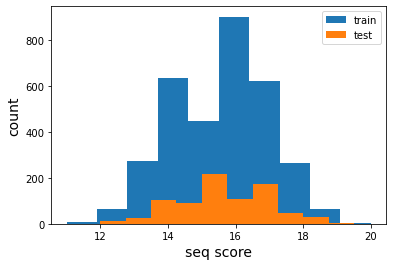

In [13]:
plot_train_test_hist(mer6_train_df, mer6_test_df)

#### Run linear model

/home/ewilson6/anaconda3/envs/torch/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9000). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607369981906/work/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


0 0.0011623799199630257
1 0.0010523620359713167
2 0.0008838477462853828
3 0.0008338474738837515
4 0.0006793571733330127
5 0.0007250696198486655
6 0.0005669204272591032
7 0.0005021003106532323
8 0.0004817861558233456
9 0.00043531464272258215
10 0.00042258325604673636
11 0.00042178726711781785
12 0.00039159969807170874
13 0.00032777110712386943
14 0.0004125408825774041
15 0.0003240578396887541
16 0.00043059420078373856
17 0.000242525333767223
18 0.00023220498581550357
19 0.00021546365494098764


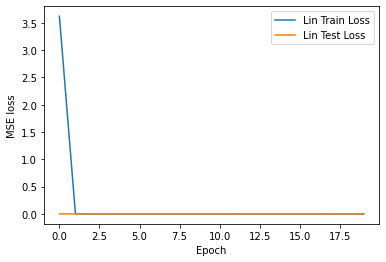

In [14]:
seq_len = len(mer6_train_df['seq'].values[0])
hidden_layer_size = 24

mer6_model_lin = DNA_Linear(seq_len, hidden_layer_size)

mer6_train_losses, mer6_test_losses = u.run_model(mer6_train_dl, mer6_test_dl, mer6_model_lin)

# to plot loss
mer6_lin_data_label = list(zip([mer6_train_losses,mer6_test_losses], ['Lin Train Loss','Lin Test Loss']))
u.quick_loss_plot(mer6_lin_data_label)

In [15]:
def quick_test(model,oracle):
    '''Spot check predictions for a few sequences '''
    seqs1 = ['AAAAAA', 'CCCCCC','GGGGGG','TTTTTT']
    seqs2 = ['AACCAA','CCGGGG','GGGTAA', 'TTTCGT','TGTAAT']
    seqsTAT = ['TATAAA','CCTATC','GTATGG','TTTATT']
    seqsGCG = ['AAGCGA','CGCGCC','GGGCGG','TTGCGT']
    TATGCG =  ['TATGCG','GCGTAT']

    for seqs in [seqs1, seqs2, seqsTAT, seqsGCG, TATGCG]:
        u.quick_seq_pred(model, seqs, oracle)
        print()

In [16]:
oracle_6mer = scoring = dict(mer6[['seq','score']].values)
quick_test(mer6_model_lin, oracle_6mer)

AAAAAA: pred:20.021 actual:20.000 (-0.021)
CCCCCC: pred:17.042 actual:17.000 (-0.042)
GGGGGG: pred:13.971 actual:14.000 (0.029)
TTTTTT: pred:11.003 actual:11.000 (-0.003)

AACCAA: pred:19.001 actual:19.000 (-0.001)
CCGGGG: pred:14.993 actual:15.000 (0.007)
GGGTAA: pred:15.502 actual:15.500 (-0.002)
TTTCGT: pred:12.526 actual:12.500 (-0.026)
TGTAAT: pred:14.500 actual:14.500 (0.000)

TATAAA: pred:17.005 actual:17.000 (-0.005)
CCTATC: pred:15.496 actual:15.500 (0.004)
GTATGG: pred:13.994 actual:14.000 (0.006)
TTTATT: pred:12.511 actual:12.500 (-0.011)

AAGCGA: pred:17.501 actual:17.500 (-0.001)
CGCGCC: pred:16.020 actual:16.000 (-0.020)
GGGCGG: pred:14.482 actual:14.500 (0.018)
TTGCGT: pred:13.008 actual:13.000 (-0.008)

TATGCG: pred:14.501 actual:14.500 (-0.001)
GCGTAT: pred:14.476 actual:14.500 (0.024)



# Single task Regression with Motifs
### Linear Model

In [17]:
mer6motif_train_dl, mer6motif_test_dl, mer6motif_train_df, mer6motif_test_df = u.build_dataloaders_single(mer6_motif,batch_size=13)

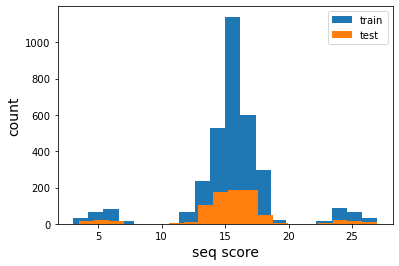

In [18]:
plot_train_test_hist(mer6motif_train_df, mer6motif_test_df,bins=20)

0 10.154756751874599
1 10.245323354151191
2 8.944285303208886
3 11.325993469284802
4 8.539987257631813
5 8.216110836005793
6 7.49009894452444
7 7.191442754210495
8 7.099442644235564
9 6.400107959421669
10 6.369677816949239
11 6.840628958911431
12 6.095117917874965
13 5.225777920571769
14 5.311041983743993
15 5.3364470749366575
16 4.684902659858145
17 4.309373957354848
18 4.107275377250299
19 3.935809838481066


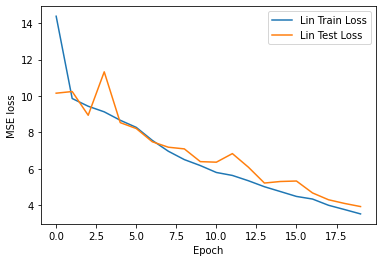

In [19]:
seq_len = len(mer6motif_train_df['seq'].values[0])
hidden_layer_size = 24

mer6motif_model_lin = DNA_Linear(seq_len, hidden_layer_size)

mer6motif_train_losses_lin, mer6motif_test_losses_lin = u.run_model(mer6motif_train_dl, mer6motif_test_dl, mer6motif_model_lin,lr=0.01)

# to plot loss
mer6motif_lin_data_label = list(zip([mer6motif_train_losses_lin,mer6motif_test_losses_lin], ['Lin Train Loss','Lin Test Loss']))
u.quick_loss_plot(mer6motif_lin_data_label)

In [21]:
oracle_6mer_motif = scoring = dict(mer6_motif[['seq','score']].values)
quick_test(mer6motif_model_lin,oracle_6mer_motif)

AAAAAA: pred:18.679 actual:20.000 (1.321)
CCCCCC: pred:17.850 actual:17.000 (-0.850)
GGGGGG: pred:11.588 actual:14.000 (2.412)
TTTTTT: pred:13.148 actual:11.000 (-2.148)

AACCAA: pred:18.703 actual:19.000 (0.297)
CCGGGG: pred:11.564 actual:15.000 (3.436)
GGGTAA: pred:16.150 actual:15.500 (-0.650)
TTTCGT: pred:12.075 actual:12.500 (0.425)
TGTAAT: pred:15.592 actual:14.500 (-1.092)

TATAAA: pred:22.859 actual:27.000 (4.141)
CCTATC: pred:22.018 actual:25.500 (3.482)
GTATGG: pred:21.722 actual:24.000 (2.278)
TTTATT: pred:20.715 actual:22.500 (1.785)

AAGCGA: pred:10.646 actual:7.500 (-3.146)
CGCGCC: pred:7.184 actual:6.000 (-1.184)
GGGCGG: pred:8.434 actual:4.500 (-3.934)
TTGCGT: pred:5.968 actual:3.000 (-2.968)

TATGCG: pred:15.617 actual:14.500 (-1.117)
GCGTAT: pred:18.352 actual:14.500 (-3.852)



### CNN Model

0 7.016954833123742
1 4.612286193487121
2 2.7705063843145603
3 2.1451512447944503
4 1.5531316632904657
5 0.7641180066800699
6 0.4835851181207634
7 0.36165755838155744
8 0.19368066306612114
9 0.21662176001544406
10 0.2657173851186909
11 0.22659322990604291
12 0.19075170714953324
13 0.2275621276303399
14 0.14920878254286035
15 9.593947612948535
16 0.4487712045995201
17 0.16149918427690862
18 0.19747481229828626
19 0.18850655281325665


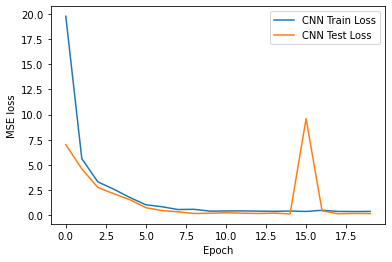

In [22]:
seq_len = len(mer6motif_train_df['seq'].values[0])

mer6motif_model_cnn = DNA_CNN(seq_len, num_filters=31,kernel_size=3)

mer6motif_train_losses_cnn, mer6motif_test_losses_cnn = u.run_model(mer6motif_train_dl, mer6motif_test_dl, mer6motif_model_cnn, lr=0.01)

# to plot loss
mer6motif_cnn_data_label = list(zip([mer6motif_train_losses_cnn,mer6motif_test_losses_cnn], ['CNN Train Loss','CNN Test Loss']))
u.quick_loss_plot(mer6motif_cnn_data_label)

In [23]:
quick_test(mer6motif_model_cnn, oracle_6mer_motif)

AAAAAA: pred:20.242 actual:20.000 (-0.242)
CCCCCC: pred:16.815 actual:17.000 (0.185)
GGGGGG: pred:13.593 actual:14.000 (0.407)
TTTTTT: pred:10.980 actual:11.000 (0.020)

AACCAA: pred:18.796 actual:19.000 (0.204)
CCGGGG: pred:14.330 actual:15.000 (0.670)
GGGTAA: pred:15.654 actual:15.500 (-0.154)
TTTCGT: pred:12.535 actual:12.500 (-0.035)
TGTAAT: pred:14.605 actual:14.500 (-0.105)

TATAAA: pred:26.166 actual:27.000 (0.834)
CCTATC: pred:24.910 actual:25.500 (0.590)
GTATGG: pred:23.581 actual:24.000 (0.419)
TTTATT: pred:22.199 actual:22.500 (0.301)

AAGCGA: pred:7.277 actual:7.500 (0.223)
CGCGCC: pred:5.686 actual:6.000 (0.314)
GGGCGG: pred:4.350 actual:4.500 (0.150)
TTGCGT: pred:4.199 actual:3.000 (-1.199)

TATGCG: pred:13.763 actual:14.500 (0.737)
GCGTAT: pred:13.941 actual:14.500 (0.559)



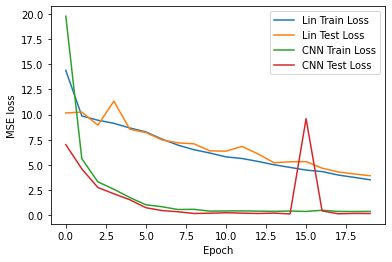

In [24]:
comb_data_label = list(zip([mer6motif_train_losses_lin,mer6motif_test_losses_lin,mer6motif_train_losses_cnn,mer6motif_test_losses_cnn], 
                          ['Lin Train Loss','Lin Test Loss','CNN Train Loss','CNN Test Loss']))

u.quick_loss_plot(comb_data_label)

# Try with 8 mers

### Single Task Regression


In [23]:
mer8_order_train_dl, mer8_order_test_dl, mer8_order_train_df, mer8_order_test_df = u.build_dataloaders_single(mer8_ordering)

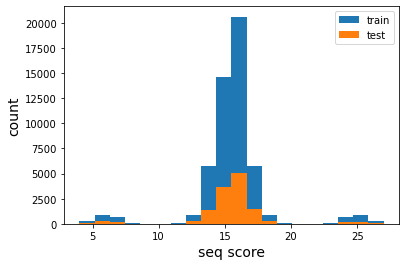

In [24]:
plot_train_test_hist(mer8_order_train_df, mer8_order_test_df,bins=20)

/home/ewilson6/anaconda3/envs/torch/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9000). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607369981906/work/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


0 5.724334390271827
1 4.37923266777077
2 3.632042119733655
3 3.4805845034206135
4 3.0557967205035967
5 3.0113983894944156
6 2.794210094702764
7 2.5533010458342362
8 2.4891236571957145
9 2.554557599779815
10 2.365073692955038
11 3.306649283443168
12 2.1923286407722147
13 2.1217379639124703
14 2.033472148645277
15 2.02828489078921
16 2.259619779327784
17 2.0517272008494847
18 1.7253288154671895
19 1.8474292946472959


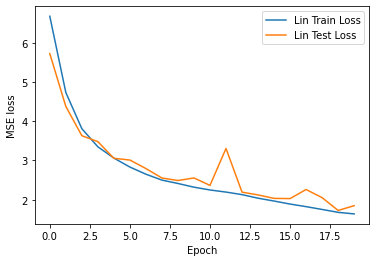

In [25]:
seq_len = len(mer8_order_train_df['seq'].values[0])
hidden_layer_size = 24

mer8_order_model_lin = DNA_Linear(seq_len, hidden_layer_size)

mer8_order_train_losses, mer8_order_test_losses = u.run_model(mer8_order_train_dl, mer8_order_test_dl, mer8_order_model_lin)

# to plot loss
mer8_order_lin_data_label = list(zip([mer8_order_train_losses,mer8_order_test_losses], ['Lin Train Loss','Lin Test Loss']))
u.quick_loss_plot(mer8_order_lin_data_label)

In [28]:
def quick_test8(model, oracle):
    seqs1 = ['AAAAAAAA', 'CCCCCCCC','GGGGGGGG','TTTTTTTT']
    seqs2 = ['AACCAACA','CCGGCGCG','GGGTAAGG', 'TTTCGTTT','TGTAATAC']
    seqsTAT = ['TATAAAAA','CCTATCCC','GTATGGGG','TTTATTTT']
    seqsGCG = ['AAGCGAAA','CGCGCCCC','GGGCGGGG','TTGCGTTT']
    #TATGCG =  ['ATATGCGA','TGCGTATT']
    ordered = ['AAGCGGAA','CGCAAGGT','GTTCGGCC','TTGCCGTT']

    for seqs in [seqs1, seqs2, seqsTAT, seqsGCG, ordered]:
        u.quick_seq_pred(model, seqs, oracle)
        print()

In [29]:
quick_test8(mer8_order_model_lin, oracle_8mer_ordering)

AAAAAAAA: pred:21.824 actual:20.000 (-1.824)
CCCCCCCC: pred:14.233 actual:17.000 (2.767)
GGGGGGGG: pred:16.075 actual:14.000 (-2.075)
TTTTTTTT: pred:10.824 actual:11.000 (0.176)

AACCAACA: pred:19.091 actual:18.875 (-0.216)
CCGGCGCG: pred:16.043 actual:15.500 (-0.543)
GGGTAAGG: pred:13.725 actual:15.125 (1.400)
TTTCGTTT: pred:11.999 actual:12.125 (0.126)
TGTAATAC: pred:15.723 actual:15.500 (-0.223)

TATAAAAA: pred:17.898 actual:17.750 (-0.148)
CCTATCCC: pred:18.325 actual:15.875 (-2.450)
GTATGGGG: pred:14.299 actual:14.000 (-0.299)
TTTATTTT: pred:12.299 actual:12.125 (-0.174)

AAGCGAAA: pred:17.727 actual:18.125 (0.398)
CGCGCCCC: pred:14.539 actual:16.250 (1.711)
GGGCGGGG: pred:15.923 actual:14.375 (-1.548)
TTGCGTTT: pred:12.931 actual:12.500 (-0.431)

AAGCGGAA: pred:11.650 actual:7.375 (-4.275)
CGCAAGGT: pred:12.423 actual:5.875 (-6.548)
GTTCGGCC: pred:21.897 actual:24.375 (2.478)
TTGCCGTT: pred:20.872 actual:23.250 (2.378)



### CNN Model

0 4.874507513357656
1 3.572330013294936
2 1.3094404042039953
3 1.0710237988583156
4 0.6563608071809139
5 0.5988118544216378
6 0.6690434355596816
7 0.7872985137793069
8 0.38966867923372794
9 0.33613260262917194
10 0.28290974383569545
11 0.27632787447055557
12 0.28307002624579236
13 0.2425397522054069
14 0.31595507165008396
15 0.22867265618089352
16 0.33571097287947643
17 1.4388361516652182
18 0.2376432085212526
19 0.20886872429826983


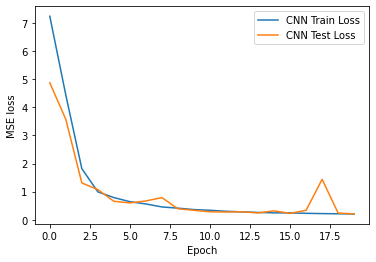

In [30]:
seq_len = len(mer8_order_train_df['seq'].values[0])

mer8_order_model_cnn = DNA_CNN(seq_len, num_filters=31,kernel_size=3)

mer8_order_train_losses_cnn, mer8_order_test_losses_cnn = u.run_model(mer8_order_train_dl, mer8_order_test_dl, mer8_order_model_cnn)

# to plot loss
mer8_order_cnn_data_label = list(zip([mer8_order_train_losses_cnn,mer8_order_test_losses_cnn], ['CNN Train Loss','CNN Test Loss']))
u.quick_loss_plot(mer8_order_cnn_data_label)

In [31]:
quick_test8(mer8_order_model_cnn, oracle_8mer_ordering)

AAAAAAAA: pred:19.335 actual:20.000 (0.665)
CCCCCCCC: pred:17.395 actual:17.000 (-0.395)
GGGGGGGG: pred:14.120 actual:14.000 (-0.120)
TTTTTTTT: pred:10.786 actual:11.000 (0.214)

AACCAACA: pred:19.398 actual:18.875 (-0.523)
CCGGCGCG: pred:15.412 actual:15.500 (0.088)
GGGTAAGG: pred:14.639 actual:15.125 (0.486)
TTTCGTTT: pred:12.162 actual:12.125 (-0.037)
TGTAATAC: pred:15.481 actual:15.500 (0.019)

TATAAAAA: pred:17.592 actual:17.750 (0.158)
CCTATCCC: pred:14.941 actual:15.875 (0.934)
GTATGGGG: pred:13.999 actual:14.000 (0.001)
TTTATTTT: pred:12.159 actual:12.125 (-0.034)

AAGCGAAA: pred:18.117 actual:18.125 (0.008)
CGCGCCCC: pred:15.930 actual:16.250 (0.320)
GGGCGGGG: pred:14.429 actual:14.375 (-0.054)
TTGCGTTT: pred:12.354 actual:12.500 (0.146)

AAGCGGAA: pred:7.732 actual:7.375 (-0.357)
CGCAAGGT: pred:6.318 actual:5.875 (-0.443)
GTTCGGCC: pred:24.136 actual:24.375 (0.239)
TTGCCGTT: pred:22.868 actual:23.250 (0.382)



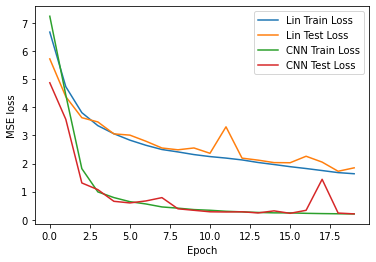

In [33]:
u.quick_loss_plot(
    mer8_order_lin_data_label + \
    mer8_order_cnn_data_label
)

# Try LSTMs

In [34]:
class DNA_LSTM(nn.Module):
    def __init__(self,seq_len,hidden_dim=10):
        super().__init__()
        self.seq_len = seq_len

        self.hidden_dim = hidden_dim
        self.hidden = None # when initialized, should be tuple of (hidden state, cell state)
        
        self.rnn = nn.LSTM(4, hidden_dim,batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
            

    
    def init_hidden(self,batch_size):
        # initialize hidden and cell states with 0s
        self.hidden =  (torch.zeros(1, batch_size, self.hidden_dim), 
                        torch.zeros(1, batch_size, self.hidden_dim))
        return self.hidden
        #hidden_state = torch.randn(n_layers, batch_size, hidden_dim)
    

    def forward(self, xb,verbose=False):
        if verbose:
            print("original xb.shape:", xb.shape)
            print(xb) # 11 x 32
        
        # make the one-hot nucleotide vectors group together
        xb = xb.view(-1,self.seq_len,4) 
        if verbose:
            print("re-viewed xb.shape:", xb.shape) # >> 11 x 8 x 4
            print(xb)

        # ** Init hidden/cell states?? **
        batch_size = xb.shape[0]
        if verbose:
            print("batch_size:",batch_size)
        (h,c) = self.init_hidden(batch_size)
         
        # *******
        
        lstm_out, self.hidden = self.rnn(xb, (h,c)) # should this get H and C?
        if verbose:
            #print("lstm_out",lstm_out)
            print("lstm_out shape:",lstm_out.shape) # >> 11, 8, 10
            print("lstm_out[-1] shape:",lstm_out[-1].shape) # >> 8 x 10
            print("lstm_out[-1][-1] shape:",lstm_out[-1][-1].shape) # 10

            print("hidden len:",len(self.hidden)) # 2
            print("hidden[0] shape:", self.hidden[0].shape) # >> 1 x 11 x 10
            print("hidden[0][-1] shape:", self.hidden[0][-1].shape) # >> 11 X 10
            print("hidden[0][-1][-1] shape:", self.hidden[0][-1][-1].shape) # >> 10

            print("*****")
            # These vectors should be the same, right?
            A = lstm_out[-1][-1]
            B = self.hidden[0][-1][-1]
            print("lstm_out[-1][-1]:",A)
            print("self.hidden[0][-1][-1]",B)
            print("==?", A==B)
            print("*****")
        
        # attempt to get the last layer from each last position of 
        # all seqs in the batch? IS this the right thing to get?
        last_layer = lstm_out[:,-1,:] # This is 11X10... and it makes FC out 11X1, which is what I want?
        #last_layer = lstm_out[-1][-1].unsqueeze(0) # this was [10X1]? led to FC outoput being [1]?
        if verbose:
            print("last layer:", last_layer.shape)

        out = self.fc(last_layer) 
        if verbose:
            print("LSTM->FC out shape:",out.shape)   
                                                
        return out

In [40]:
seq_len = len(mer8_order_train_df['seq'].values[0])

mer8_order_model_lstm = DNA_LSTM(seq_len)
mer8_order_model_lstm

DNA_LSTM(
  (rnn): LSTM(4, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

In [41]:
mer8_order_train_losses_lstm,\
mer8_order_test_losses_lstm = u.run_model(
    mer8_order_train_dl, 
    mer8_order_test_dl, 
    mer8_order_model_lstm
)


0 6.290126712648906
1 6.338115298678899
2 4.655868077154453
3 3.192561430577501
4 2.7831377372677673
5 1.5656400261981698
6 0.7105382601589847
7 0.5552468198190421
8 0.425828290669555
9 0.3854135623111352
10 0.3104819993729776
11 0.3324249464453522
12 0.22368771727215345
13 0.3597157295426109
14 0.20569930044404974
15 0.18215019960919276
16 0.1724594031160184
17 0.17132127961626423
18 0.14971894037170602
19 0.1786391998314079


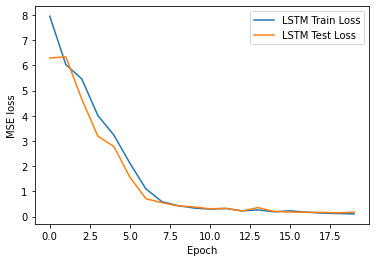

In [42]:
mer8_order_lstm_data_label = list(zip([mer8_order_train_losses_lstm,mer8_order_test_losses_lstm], ['LSTM Train Loss','LSTM Test Loss']))
u.quick_loss_plot(mer8_order_lstm_data_label)

In [43]:
quick_test8(mer8_order_model_lstm, oracle_8mer_ordering)

AAAAAAAA: pred:20.456 actual:20.000 (-0.456)
CCCCCCCC: pred:16.581 actual:17.000 (0.419)
GGGGGGGG: pred:14.230 actual:14.000 (-0.230)
TTTTTTTT: pred:10.477 actual:11.000 (0.523)

AACCAACA: pred:18.497 actual:18.875 (0.378)
CCGGCGCG: pred:15.792 actual:15.500 (-0.292)
GGGTAAGG: pred:15.173 actual:15.125 (-0.048)
TTTCGTTT: pred:11.900 actual:12.125 (0.225)
TGTAATAC: pred:15.517 actual:15.500 (-0.017)

TATAAAAA: pred:18.182 actual:17.750 (-0.432)
CCTATCCC: pred:15.900 actual:15.875 (-0.025)
GTATGGGG: pred:14.243 actual:14.000 (-0.243)
TTTATTTT: pred:12.242 actual:12.125 (-0.117)

AAGCGAAA: pred:18.187 actual:18.125 (-0.062)
CGCGCCCC: pred:16.261 actual:16.250 (-0.011)
GGGCGGGG: pred:14.362 actual:14.375 (0.013)
TTGCGTTT: pred:12.732 actual:12.500 (-0.232)

AAGCGGAA: pred:7.340 actual:7.375 (0.035)
CGCAAGGT: pred:6.093 actual:5.875 (-0.218)
GTTCGGCC: pred:24.075 actual:24.375 (0.300)
TTGCCGTT: pred:23.740 actual:23.250 (-0.490)



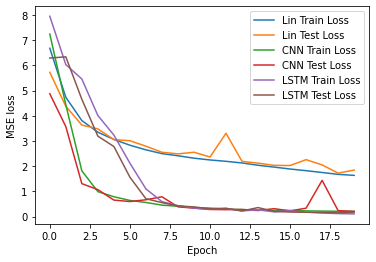

In [44]:
u.quick_loss_plot(
    mer8_order_lin_data_label + \
    mer8_order_cnn_data_label + \
    mer8_order_lstm_data_label
)

# Try CNN+LSTM

In [45]:
class DNA_CNNLSTM(nn.Module):
    def __init__(self,
                 seq_len,
                 hidden_dim=10,
                 num_filters=32,
                 kernel_size=3):
        super().__init__()
        self.seq_len = seq_len
        
        self.conv_net = nn.Sequential(
            nn.Conv1d(4, num_filters, kernel_size=kernel_size),
            nn.ReLU(inplace=True),
        ) 
        
        self.hidden_dim = hidden_dim
        self.hidden = None # when initialized, should be tuple of (hidden state, cell state)
        
        self.rnn = nn.LSTM(num_filters, hidden_dim,batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
            
    def init_hidden(self,batch_size):
        # initialize hidden and cell states with 0s
        self.hidden =  (torch.zeros(1, batch_size, self.hidden_dim), 
                        torch.zeros(1, batch_size, self.hidden_dim))
        return self.hidden
        #hidden_state = torch.randn(n_layers, batch_size, hidden_dim)

    def forward(self, xb, verbose=False):
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        xb = xb.view(-1,self.seq_len,4).permute(0,2,1) 
        if verbose:
            print("xb reviewed shape:",xb.shape)

        cnn_out = self.conv_net(xb)
        if verbose:
            print("CNN out shape:",cnn_out.shape)
        cnn_out_perm = cnn_out.permute(0,2,1)
        if verbose:
            print("CNN permute out shape:",cnn_out_perm.shape)
        
        batch_size = xb.shape[0]
        if verbose:
            print("batch_size:",batch_size)
        (h,c) = self.init_hidden(batch_size)
        
        lstm_out, self.hidden = self.rnn(cnn_out_perm, (h,c)) # should this get H and C?
        
        last_layer = lstm_out[:,-1,:] # This is 11X10... and it makes FC out 11X1, which is what I want?
        if verbose:
            print("last layer:", last_layer.shape)

        out = self.fc(last_layer) 
        if verbose:
            print("LSTM->FC out shape:",out.shape)        
        
        return out

In [46]:
seq_len = len(mer8_order_train_df['seq'].values[0])

mer8_order_model_cnnlstm = DNA_CNNLSTM(seq_len)
mer8_order_model_cnnlstm

DNA_CNNLSTM(
  (conv_net): Sequential(
    (0): Conv1d(4, 32, kernel_size=(3,), stride=(1,))
    (1): ReLU(inplace=True)
  )
  (rnn): LSTM(32, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

In [47]:
mer8_order_train_losses_cnnlstm,\
mer8_order_test_losses_cnnlstm = u.run_model(
    mer8_order_train_dl, 
    mer8_order_test_dl, 
    mer8_order_model_cnnlstm
)


0 5.647287289325806
1 2.1449943810364878
2 1.0638036311745898
3 0.4458785356273366
4 0.2226052634829532
5 0.1619852172426236
6 0.13718326375238554
7 0.07206234750148906
8 0.17501386533996335
9 0.05246656230484017
10 0.0539195028349398
11 0.03873820272540042
12 0.034670357892234625
13 0.046953626767114634
14 0.02900499803789112
15 0.038855643203464414
16 0.02287169945132707
17 0.020309083862869632
18 0.03455398916893519
19 0.017605340070192647


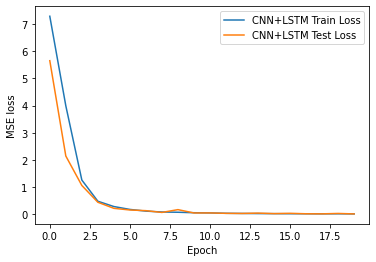

In [48]:
mer8_order_cnnlstm_data_label = list(zip([mer8_order_train_losses_cnnlstm,mer8_order_test_losses_cnnlstm], ['CNN+LSTM Train Loss','CNN+LSTM Test Loss']))
u.quick_loss_plot(mer8_order_cnnlstm_data_label)

In [49]:
quick_test8(mer8_order_model_cnnlstm, oracle_8mer_ordering)

AAAAAAAA: pred:20.579 actual:20.000 (-0.579)
CCCCCCCC: pred:16.429 actual:17.000 (0.571)
GGGGGGGG: pred:13.946 actual:14.000 (0.054)
TTTTTTTT: pred:11.029 actual:11.000 (-0.029)

AACCAACA: pred:18.782 actual:18.875 (0.093)
CCGGCGCG: pred:15.438 actual:15.500 (0.062)
GGGTAAGG: pred:15.350 actual:15.125 (-0.225)
TTTCGTTT: pred:12.119 actual:12.125 (0.006)
TGTAATAC: pred:15.564 actual:15.500 (-0.064)

TATAAAAA: pred:17.880 actual:17.750 (-0.130)
CCTATCCC: pred:15.658 actual:15.875 (0.217)
GTATGGGG: pred:14.123 actual:14.000 (-0.123)
TTTATTTT: pred:11.800 actual:12.125 (0.325)

AAGCGAAA: pred:18.094 actual:18.125 (0.031)
CGCGCCCC: pred:16.206 actual:16.250 (0.044)
GGGCGGGG: pred:14.445 actual:14.375 (-0.070)
TTGCGTTT: pred:12.483 actual:12.500 (0.017)

AAGCGGAA: pred:7.111 actual:7.375 (0.264)
CGCAAGGT: pred:5.844 actual:5.875 (0.031)
GTTCGGCC: pred:23.822 actual:24.375 (0.553)
TTGCCGTT: pred:23.330 actual:23.250 (-0.080)



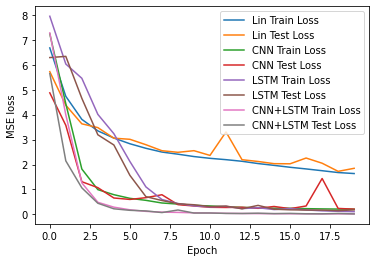

In [50]:
u.quick_loss_plot(
    mer8_order_lin_data_label + \
    mer8_order_cnn_data_label + \
    mer8_order_lstm_data_label + \
    mer8_order_cnnlstm_data_label
)

In [60]:
def quick_pred(models, oracle):
    '''Given some sequences, get the model's predictions '''
    seqs1 = ['AAAAAAAA', 'CCCCCCCC','GGGGGGGG','TTTTTTTT']
    seqs2 = ['AACCAACA','CCGGCGCG','GGGTAAGG', 'TTTCGTTT','TGTAATAC']
    seqsTAT = ['TATAAAAA','CCTATCCC','GTATGGGG','TTTATTTT']
    seqsGCG = ['AAGCGAAA','CGCGCCCC','GGGCGGGG','TTGCGTTT']
    #TATGCG =  ['ATATGCGA','TGCGTATT']
    ordered = ['AAGCGGAA','CGCAAGGT','GTTCGGCC','TTGCCGTT']
    
    data = []
    for seq_type,seqs in [
        ("poly",seqs1), 
        ("medley",seqs2), 
        ("TAT",seqsTAT), 
        ("GCG",seqsGCG), 
        ("ordered",ordered)]:
        
        for dna in seqs:
            s = torch.tensor(u.one_hot_encode(dna))
            actual = oracle[dna]
            for model_name,model in models:
                pred = model(s.float())
                diff = actual - pred.item()
                data.append([dna,seq_type, model_name, actual, pred.item(), diff])
            
    return pd.DataFrame(data, columns=['seq','seq_type','model','truth','pred','diff'])
        

In [61]:
models = [
    ("Linear",mer8_order_model_lin),
    ("CNN",mer8_order_model_cnn),
    ("LSTM",mer8_order_model_lstm),
    ("CNN+LSTM",mer8_order_model_cnnlstm)
]

pred_df = quick_pred(models,oracle_8mer_ordering)

In [62]:
pred_df

,seq,seq_type,model,truth,pred,diff
0,AAAAAAAA,poly,Linear,20.000,21.823828,-1.823828
1,AAAAAAAA,poly,CNN,20.000,19.334791,0.665209
2,AAAAAAAA,poly,LSTM,20.000,20.456327,-0.456327
3,AAAAAAAA,poly,CNN+LSTM,20.000,20.578959,-0.578959
4,CCCCCCCC,poly,Linear,17.000,14.232910,2.767090
...,...,...,...,...,...,...
79,GTTCGGCC,ordered,CNN+LSTM,24.375,23.822428,0.552572
80,TTGCCGTT,ordered,Linear,23.250,20.872171,2.377829
81,TTGCCGTT,ordered,CNN,23.250,22.868187,0.381813
82,TTGCCGTT,ordered,LSTM,23.250,23.740463,-0.490463


In [64]:
import seaborn as sns

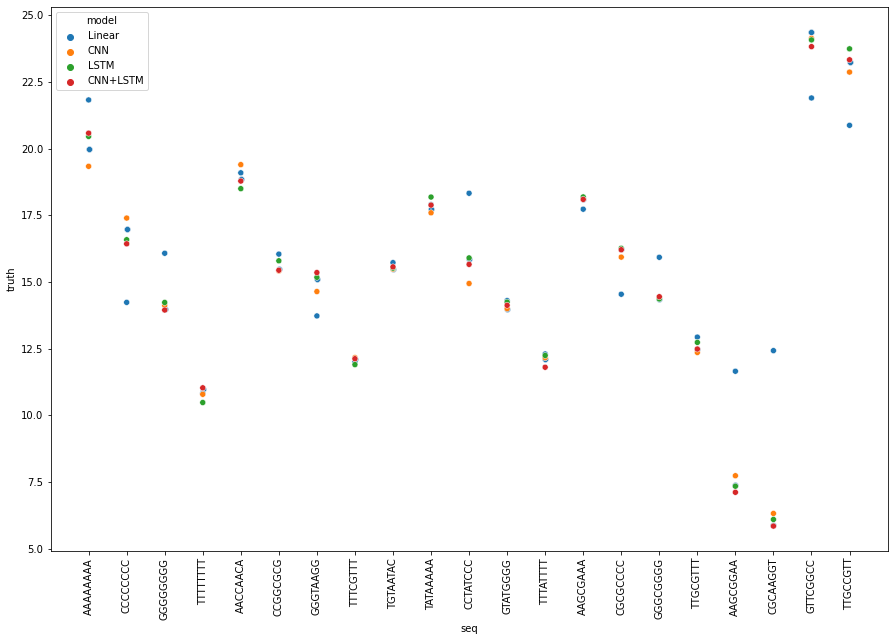

In [77]:
plt.figure(figsize=(15,10))
sns.scatterplot(data=pred_df,x='seq',y='truth')
sns.scatterplot(data=pred_df,x='seq',y='pred',hue="model")
plt.xticks(rotation=90)
plt.show()

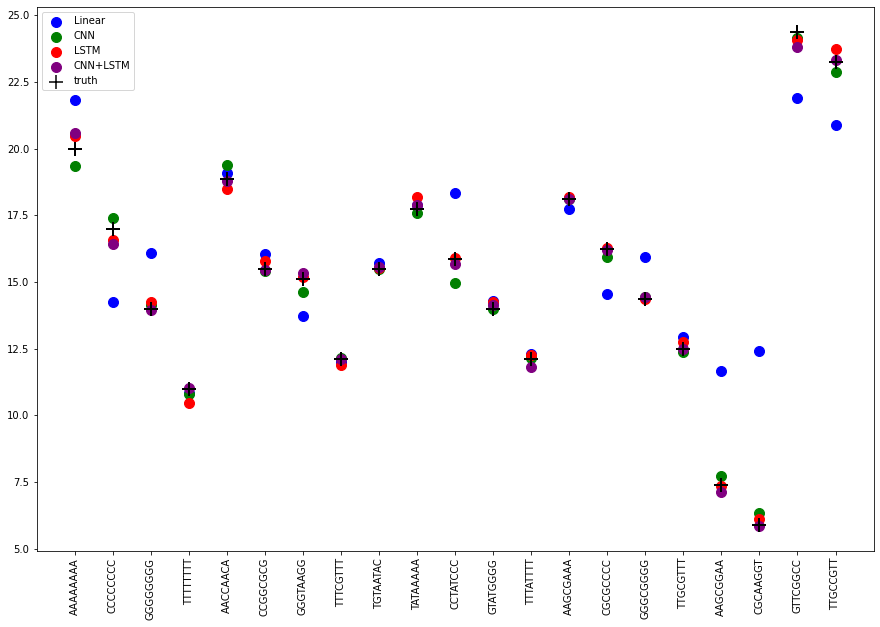

In [97]:
plt.figure(figsize=(15,10))
plt.scatter(data=pred_df[pred_df['model']=='Linear'],x='seq',y='pred',color='blue',s=100,label='Linear')
plt.scatter(data=pred_df[pred_df['model']=='CNN'],x='seq',y='pred',color='green',s=100,label='CNN')
plt.scatter(data=pred_df[pred_df['model']=='LSTM'],x='seq',y='pred',color='red',s=100,label='LSTM')
plt.scatter(data=pred_df[pred_df['model']=='CNN+LSTM'],x='seq',y='pred',color='purple',s=100,label='CNN+LSTM')

plt.scatter(data=pred_df,x='seq',y='truth',marker='+',color='black',s=200)
#sns.scatterplot(data=pred_df,x='seq',y='pred',hue="model")
plt.legend(loc='best')
plt.xticks(rotation=90)
plt.show()

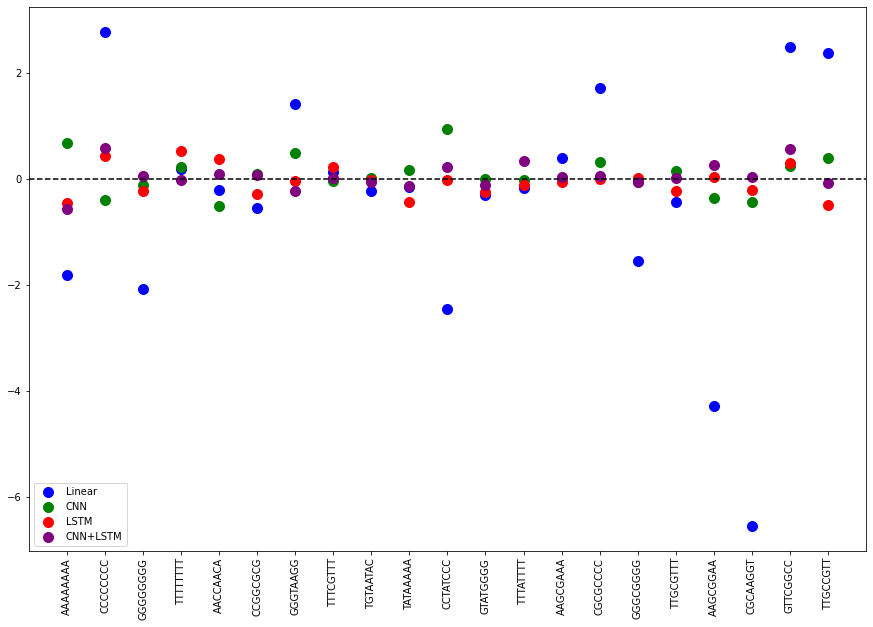

In [106]:
plt.figure(figsize=(15,10))
plt.scatter(data=pred_df[pred_df['model']=='Linear'],x='seq',y='diff',color='blue',s=100,label='Linear')
plt.scatter(data=pred_df[pred_df['model']=='CNN'],x='seq',y='diff',color='green',s=100,label='CNN')
plt.scatter(data=pred_df[pred_df['model']=='LSTM'],x='seq',y='diff',color='red',s=100,label='LSTM')
plt.scatter(data=pred_df[pred_df['model']=='CNN+LSTM'],x='seq',y='diff',color='purple',s=100,label='CNN+LSTM')

plt.axhline(y=0,linestyle='--',color='black')
#sns.scatterplot(data=pred_df,x='seq',y='pred',hue="model")
plt.legend(loc='best')
plt.xticks(rotation=90)
plt.show()

In [159]:
def parity_plot(model,df, pearson):
    plt.scatter(df['pred'].values, df['truth'].values, alpha=0.2)
    plt.xlabel("Predicted Score",fontsize=14)
    plt.ylabel("Actual Score",fontsize=14)
    plt.title(f"{model} (pearson:{pearson:.3f})",fontsize=20)
    plt.show()
    
def alt_parity_plot(model,df, pearson,task):
    chart = alt.Chart(df).mark_circle(opacity=0.2).encode(
        alt.X('pred:Q'),
        alt.Y('truth:Q'),
        tooltip=['seq:N']
    ).properties(
        title=f'Model (pearson:{pearson})'
    ).interactive()
    
    chart.save(f'alt_out/parity_plot_{model}_{task}.html')
    

def parity_pred(models, seqs, oracle,task,alt=True):
    '''Given some sequences, get the model's predictions '''
    dfs = {} # key: model name, value: parity_df
    
    
    for model_name,model in models:
        print(f"Running {model_name}")
        data = []
        for dna in seqs:
            s = torch.tensor(u.one_hot_encode(dna))
            actual = oracle[dna]
            pred = model(s.float())
            data.append([dna,actual,pred.item()])
        df = pd.DataFrame(data, columns=['seq','truth','pred'])
        pearson = df['truth'].corr(df['pred'])
        dfs[model_name] = (pearson,df)
        
        #plot parity plot
        if alt: # make an altair plot
            alt_parity_plot(model_name, df, pearson,task)
        parity_plot(model_name, df, pearson)

    return dfs

In [160]:
test_set_seqs = mer8_order_test_df['seq'].values
task = "ordered_motif"
parity_dfs = parity_pred(models,test_set_seqs,oracle_8mer_ordering,task)

Running Linear
Running CNN
Running LSTM
Running CNN+LSTM


In [153]:
test_set_seqs.shape

(13108,)

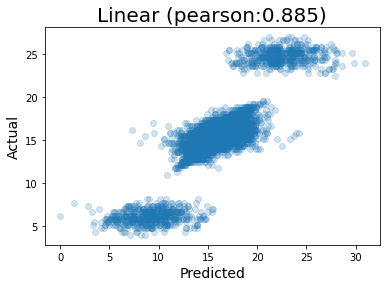

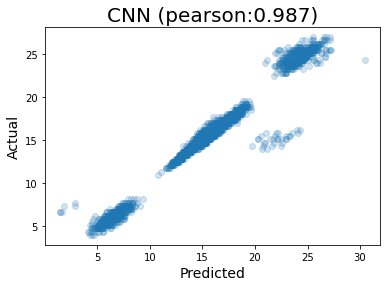

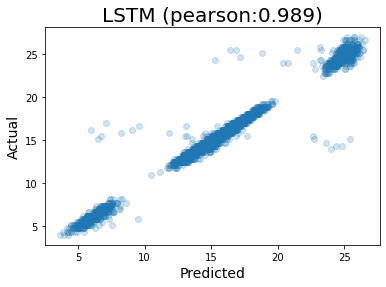

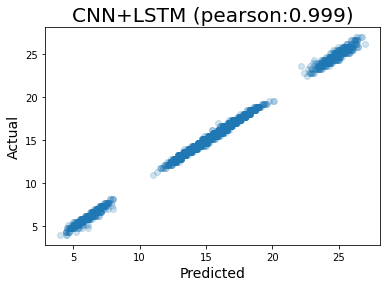

In [142]:
for model in parity_dfs:
    parity_plot(model, parity_dfs[model][1],parity_dfs[model][0])

In [ ]:
# first LSTM run??

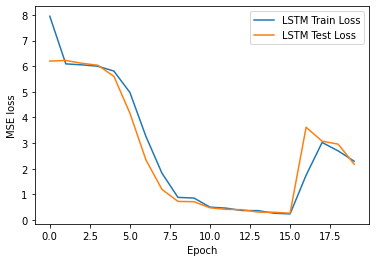

In [37]:
mer8_order_lstm_data_label = list(zip([mer8_order_train_losses_lstm,mer8_order_test_losses_lstm], ['LSTM Train Loss','LSTM Test Loss']))
u.quick_loss_plot(mer8_order_lstm_data_label)

In [38]:
quick_test8(mer8_order_model_lstm, oracle_8mer_ordering)

AAAAAAAA: pred:19.870 actual:20.000 (0.130)
CCCCCCCC: pred:16.607 actual:17.000 (0.393)
GGGGGGGG: pred:13.460 actual:14.000 (0.540)
TTTTTTTT: pred:11.152 actual:11.000 (-0.152)

AACCAACA: pred:19.794 actual:18.875 (-0.919)
CCGGCGCG: pred:15.961 actual:15.500 (-0.461)
GGGTAAGG: pred:13.801 actual:15.125 (1.324)
TTTCGTTT: pred:13.708 actual:12.125 (-1.583)
TGTAATAC: pred:15.514 actual:15.500 (-0.014)

TATAAAAA: pred:17.713 actual:17.750 (0.037)
CCTATCCC: pred:15.882 actual:15.875 (-0.007)
GTATGGGG: pred:12.882 actual:14.000 (1.118)
TTTATTTT: pred:12.472 actual:12.125 (-0.347)

AAGCGAAA: pred:18.080 actual:18.125 (0.045)
CGCGCCCC: pred:16.388 actual:16.250 (-0.138)
GGGCGGGG: pred:13.765 actual:14.375 (0.610)
TTGCGTTT: pred:14.435 actual:12.500 (-1.935)

AAGCGGAA: pred:15.110 actual:7.375 (-7.735)
CGCAAGGT: pred:13.606 actual:5.875 (-7.731)
GTTCGGCC: pred:22.763 actual:24.375 (1.612)
TTGCCGTT: pred:21.895 actual:23.250 (1.355)



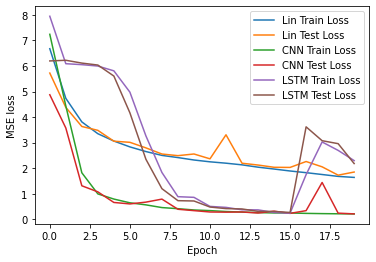

In [39]:
u.quick_loss_plot(
    mer8_order_lin_data_label + \
    mer8_order_cnn_data_label + \
    mer8_order_lstm_data_label
)

Lstm seems to eventually get down to the same level as CNN but then jumps back up at the end?? weird??